<a href="https://colab.research.google.com/github/jwarren3/csc591-602/blob/master/FederatedLearning_V9_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
############
#INSTALL PySyft
# SOURCES: 
# https://www.openmined.org/
# https://github.com/OpenMined/PySyft/tree/master/

##########

!git clone https://github.com/OpenMined/PySyft.git
!cd PySyft/
!pip install -r PySyft/pip-dep/requirements.txt
!pip install -r PySyft/pip-dep/requirements_udacity.txt
!python PySyft/setup.py install

In [0]:
# ---> IMPORTANT: Before running this cell make sure to restrat runtime (In Google Colab: Runtime> Restart Runtime)
# Run this cell to add PySyft path 
import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import keras
from keras import backend as K
from collections import Counter
import random
import scipy
from pprint import pprint as pp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
import syft as sy  # import the Pysyft library
hook = sy.TorchHook(torch)  # hook PyTorch to add extra functionalities to support Federated Learning


Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [0]:
# Create Agents to train model federately

# Benign + Malicious Agents

Agent_1 = sy.VirtualWorker(hook, id="Agent_1")
Agent_2 = sy.VirtualWorker(hook, id="Agent_2")
Agent_3 = sy.VirtualWorker(hook, id="Agent_3")
Agent_4 = sy.VirtualWorker(hook, id="Agent_4")
Agent_5 = sy.VirtualWorker(hook, id="Agent_5")
Agent_6 = sy.VirtualWorker(hook, id="Agent_6")
Agent_7 = sy.VirtualWorker(hook, id="Agent_7")
Agent_8 = sy.VirtualWorker(hook, id="Agent_8")
Agent_9 = sy.VirtualWorker(hook, id="Agent_9")
Agent_10 = sy.VirtualWorker(hook, id="Agent_10")



In [0]:
# Class to introduce training parameters
# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb

# Hyperparameter tuning

'''
Create an argument object that has model training parameters.

Arguments:

Learning Rate: Tried with 0.005, 0.001. Optimal performance found with 0.001. 0.005 is too high to train on 15,000 images
SGD momentum: Tried with 0.5, 0.99, 0.9. Optimal performance found with 0.9
Batch Size: 60

'''
class Arguments():
    def __init__(self):
        self.batch_size = 60
        self.test_batch_size = 1000
        self.epochs = 1
        self.lr = 0.004
        self.momentum = 0.9
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.mal = True
        self.targeted = True
        self.smart_mal_agent = True
        
args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [6]:
# Create testloader object to test performance of the Global Model.
# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb

# This is the dataset that will be used repeateadly to test model performance
# No Augmentation applied. The only transformations are normaliztion.

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('../data', train=False, download=True, 
                                                                transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=args.test_batch_size, shuffle=True, **kwargs)

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


In [0]:
# Create a class to return a neural network object.
# The neural network is very basic with only 2 convolutional layers. Even though the model is basic it still gives
# high accuracy on the dataset ~ 80%

# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
# Create model and set optimization values to be used for training.

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

In [0]:
# Function to calculate training loss and accuracy.
# Returns training loss and accuracy
# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb

def test(args, model, device, test_loader):
    model.eval() # Sets model for evaluaiton mode. 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Accuracy:', 100. * correct / len(test_loader.dataset))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [0]:
# Returns: Fashion MINST dataset
def get_train_data():
  mnist_full_train_dataset = datasets.FashionMNIST('../data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
  return mnist_full_train_dataset

In [0]:
class Agent:
  def __init__(self, location, malicious):
    self.location = location
    self.malicious = malicious
def train_agents(locations, mal_locations, model, Current_model, device, federated_train_loader, mal_federated_train_loader, optimizer,batch_size,EPOCHS, mal_epochs=None):
  agents = []
  for location in locations:
    agents.append(Agent(location, location in mal_locations))
  model.train()
  batch_count = len(federated_train_loader)//len(locations)
  print('Batch count: %s' % (batch_count,))
  for epc in range(EPOCHS):
    print('Epoch %d malicious agents: %s' %(epc, ','.join([agent.location.id for agent in agents if agent.malicious])))
    maliciouses = []
    # Skip benign loader if all malicious.
    if len(locations) > len(mal_locations):
      maliciouses.append(False)
    # Skip malicious loader if none malicious.
    if len(mal_locations) > 0:
      maliciouses.append(True)
    for malicious in maliciouses:
      print('Setting loader, malicious: %s' % (malicious))
      loader = mal_federated_train_loader if malicious else federated_train_loader
      for agent in agents:
        agent.batch_no = 0
      for batch_idx, (data, target) in enumerate(loader): # <-- now it is a distributed dataset
        for agent in agents:
          if agent.malicious != malicious:
            continue
          if data.location == agent.location:
            agent.batch_no += 1
            # Not last epoch
            if epc < (EPOCHS-1):
              if epc ==0 and agent.batch_no ==1:
                print("Loading state from current model")
                model.load_state_dict(Current_model.state_dict())
              if epc != 0 and agent.batch_no == 1:
                print("Loading state from last epoch %s" % (agent.location.id))
                model.load_state_dict(agent.model_params_frm_last_epoch)
              cal_grad_bkpropgt_return_delta(data,target,batch_idx,loader,model,device,epc)
              # Last batch in epoch
              if agent.batch_no == batch_count:
                print("Saving epoch state to %s" % (agent.location.id))
                agent.model_params_frm_last_epoch = model.state_dict()
                agent.model_params_frm_last_epoch = copy.deepcopy(agent.model_params_frm_last_epoch)
            else:
              if agent.batch_no == 1 and EPOCHS>1:
                print("Loading state from last epoch %s" % (agent.location.id))
                model.load_state_dict(agent.model_params_frm_last_epoch)
              cal_grad_bkpropgt_return_delta(data,target,batch_idx,loader,model,device,epc)
              if agent.batch_no == batch_count:
                agent.delta = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
                #print('Resetting model to current model for next agent; models are equal: %s' % (models_equal(model, Current_model,)))
                model.load_state_dict(Current_model.state_dict())
  deltas = []
  for agent in agents:
    deltas.append(agent.delta)
  return tuple(deltas)

In [0]:


def shuffle_dataset(ds):
  shuffled = copy.deepcopy(ds)
  indices = [i for i in range(len(ds))]
  random.shuffle(indices)
  for map_index in range(len(indices)):
    shuffled.data[map_index] = ds.data[indices[map_index]]
    shuffled.targets[map_index] = ds.targets[indices[map_index]]
  return shuffled
def get_paired_data_loaders(ds, agents, batch_size=60, shuffle=True):
  if shuffle:
    ds = shuffle_dataset(ds)
  mal_ds = copy.deepcopy(ds)
  for idx in range(len(mal_ds)):
    if mal_ds.targets[idx] == 5:
      mal_ds.targets[idx] = 7
  shards = ds.federate(agents)
  benign = sy.FederatedDataLoader(shards, batch_size=batch_size, shuffle=False, **kwargs)
  malicious_shards = mal_ds.federate(agents)
  malicious = sy.FederatedDataLoader(malicious_shards, batch_size=batch_size, shuffle=False, **kwargs)
  return benign, malicious

In [0]:
# Helper function to calculate updated model training parameters by training the model federately

# Does not return anything.

def cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epoch):
  #print('BEFORE: ',model.state_dict()['conv2.bias'])
  model.send(data.location) # <-- NEW: send the model to the right location
  data, target = data.to(device), target.to(device)
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  model.get() # <-- NEW: get the model back
  #print('AFTER: ',model.state_dict()['conv2.bias'])
  if batch_idx % args.log_interval == 0:
      loss = loss.get() # <-- NEW: get the loss back

      print('Agent: {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          data.location,epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
          100. * batch_idx / len(federated_train_loader), loss.item()))
      


In [0]:
# Helper function to boost weight delta

def boost_update(delta,boost_factor,update_weights_only = True):
  if update_weights_only:
    for nam,param in delta.items():
      if re.split('\.',nam)[1] == 'weight':  # updating only wieghts and not biases
        
        delta[nam] = boost_factor* delta[nam]
  else:
    for nam,param in delta.items():
      delta[nam] = boost_factor* delta[nam]
  
  return delta

In [0]:
# Helper functions to calculate average weight delta and to calculate updated weights for the model


def updated_weights(model,delta,update_weights=True):
  if update_weights:
    for name,param in model.state_dict().items():
      if re.split('\.',name)[1] == 'weight': # only updating weights
        new_weights = {name: model.state_dict()[name] + delta[name] for name in model.state_dict()}
  else:
    for name,param in model.state_dict().items():
      new_weights = {name: model.state_dict()[name] + delta[name] for name in model.state_dict()}  
  return new_weights


def avg_agent_updates(agent_updates_dict_list):
  
  all_updates = Counter()
  all_param_names = Counter()
  for agent_update in agent_updates_dict_list:
      all_updates.update(agent_update)
      all_param_names.update(agent_update.keys())

  averaged_updates_delta = {x: (1.0 * all_updates[x])/all_param_names[x] for x in all_updates.keys()}

  return averaged_updates_delta

In [0]:
def score_each_agent(new_distance):
  scores = {}
  sorted_order=[]
  for weight in new_distance.keys():
    for from_agent in new_distance[weight].keys():
      sorted_order = sorted(new_distance[weight][from_agent], key=lambda k: new_distance[weight][from_agent][k])
      print(sorted_order)
      for i in range(len(sorted_order)):
        if sorted_order[i] in scores.keys():
          scores[sorted_order[i]] += (i+1)*10
        else:
          scores[sorted_order[i]] = (i+1)*10
  return scores

In [0]:
def detect_mal_update(agent_deltas):
  ## Vishwas's code. For now always returning Agent 10
  distance_between_agents = {}
  new_distance = {}
  agents = ['Agent1','Agent2','Agent3','Agent4','Agent5','Agent6','Agent7','Agent8','Agent9','Agent10']
  # agent_pairs = []
  for key in agent_deltas[0].keys():
    if 'weight' in key:
      new_distance[key]={}
      distance_between_agents[key]={}
      for agent1 in agents:
        for agent2 in agents:
          if (agent1 != agent2) and ((agent1,agent2) not in distance_between_agents[key].keys()) and ((agent2,agent1) not in distance_between_agents[key].keys()):
            distance_between_agents[key][(agent1,agent2)] = 0
  for key in new_distance.keys():
    for i in range(len(agent_deltas)):
      new_distance[key][agents[i]]={}
      for j in range(len(agent_deltas)):
          # print(agent1['conv2.weight'].cpu().numpy())
        pair = (str(agents[i]),str(agents[j]))
        if i!=j:
            distance = torch.cdist(agent_deltas[i][key],agent_deltas[j][key],p=2, compute_mode='use_mm_for_euclid_dist_if_necessary')
            avg_distance = torch.mean(distance).item()
            # print(avg_distance)
            distance_between_agents[key][pair]=avg_distance
            new_distance[key][agents[i]][agents[j]] = avg_distance
          # distance = scipy.spatial.distance.cdist(agent1[key].cpu().numpy(), agent2[key].cpu().numpy(), metric='cityblock')
          # print(np.mean(distance))
          # print(distance)
  # pp(distance_between_agents)
  pp(new_distance)
  scores=score_each_agent(new_distance)
  highest_score = sorted(scores, key=lambda k: scores[k])
  #print(highest_score[-1])
  print(highest_score)
  print(scores)
  mal_del = [agent_deltas[agents.index(highest_score[-1])]]
  del agent_deltas[agents.index(highest_score[-1])]
  return agent_deltas,mal_del

In [0]:
def misclassification_conf(org_ds,model):
  org_class5_examples = 0
  pred_class5_examples = 0
  confidence = []
  for i in range(len(org_ds)):
    if org_ds.targets[i] != 5:
      continue
    output = model(org_ds[i][0].resize_((1,1,28,28)).cuda())
    pred = output.argmax(1, keepdim=True)
    org_class5_examples += 1
    if pred == 7:
      pred_class5_examples +=1
    conf = torch.nn.functional.softmax(output, dim=1)
    confidence.append(conf)
  
  return (100.0*pred_class5_examples/org_class5_examples), confidence

In [0]:
def run_for_n_timestamps(timestamps, agents,org_ds,prevent_attack=False,epochs=5,mal_Agent=[Agent_10],chng_weights_only=False):
  global_model_accuracy = []
  global_model_conf_on_misclassification = []
  mal_delta_all_ts = []
  benign_deltas_all_ts = []
  boost_factor = len(agents)/len(mal_Agent)
  mal_indices = []
  for i in range (len(agents)):
    if agents[i] in mal_Agent:
      mal_indices.append(i)
  print("Indices of malicious agents: %s" % mal_indices)

  for ts in range(timestamps):
    #delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8, delta_Agent_9, delta_Agent_10 = train_agents(agents, [Agent_10], model, Current_model, device, federated_train_loader, mal_federated_train_loader, optimizer, 60, 5)
    deltas = train_agents(agents, mal_Agent, model, Current_model, device, federated_train_loader, mal_federated_train_loader, optimizer, 60, epochs)
    
    ALL_agent_updates_ts = []

    for i in range(len(deltas)):
      delta = deltas[i]
      if i in mal_indices:
        # Mimic malicious agent boosting its weight delta
        delta = boost_update(delta, boost_factor, chng_weights_only)
      ALL_agent_updates_ts.append(delta)
 
    # If attacks have to be prevented send all deltas to function to detect malicious updates
    if prevent_attack:
      ALL_benign_agent_updates_ts, mal_delta = detect_mal_update(ALL_agent_updates_ts)
      #ALL_agent_updates_ts = [delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8,delta_Agent_9]
      #print('Agents adding weights in this update:',len(ALL_agent_updates_ts))
      mal_delta_all_ts.append(mal_delta)
    average_delta_all_Agents = avg_agent_updates(ALL_benign_agent_updates_ts)
    benign_deltas_all_ts.append(ALL_benign_agent_updates_ts)
    # Calculate Global model's accuracy on updated weights
    ALL_agent_mod_weights = updated_weights(Current_model,average_delta_all_Agents,chng_weights_only)
    Current_model_ts_plus_n_ALL_AGENTS = Net().to(device)
    Current_model_ts_plus_n_ALL_AGENTS.load_state_dict(ALL_agent_mod_weights)
    loss_, main_accuracy_ = test(args, Current_model_ts_plus_n_ALL_AGENTS, device, test_loader)
    print('Timestamp {}. Loss is {:.6f}. Accuracy is {:.2f}'.format(ts,loss_,main_accuracy_))
    global_model_accuracy.append(main_accuracy_)
    confidence,_s = misclassification_conf(org_ds,Current_model_ts_plus_n_ALL_AGENTS)
    global_model_conf_on_misclassification.append(confidence)
    
    # Load updated weights to the Global model for next timestamp
    model.load_state_dict(ALL_agent_mod_weights)
    Current_model.load_state_dict(model.state_dict())

  return global_model_accuracy,global_model_conf_on_misclassification,mal_delta_all_ts,benign_deltas_all_ts


In [0]:
def delta_distribution(benign_deltas,malicious_delta):
  avg_benign_agents = avg_agent_updates(benign_deltas)
  #mal_delta = avg_agent_updates(malicious_delta)
  norm_delta = np.hstack((K.get_value(K.flatten(avg_benign_agents['conv1.weight'].cpu())),K.get_value(K.flatten(avg_benign_agents['conv2.weight'].cpu())),
                              K.get_value(K.flatten(avg_benign_agents['fc1.weight'].cpu())),K.get_value(K.flatten(avg_benign_agents['fc2.weight'].cpu())))).ravel()
  mal_delta = np.hstack((K.get_value(K.flatten(malicious_delta['conv1.weight'].cpu())),K.get_value(K.flatten(malicious_delta['conv2.weight'].cpu())),
                              K.get_value(K.flatten(malicious_delta['fc1.weight'].cpu())),K.get_value(K.flatten(malicious_delta['fc2.weight'].cpu())))).ravel()
  #K.get_value(K.flatten(delta_mal_Agent['conv2.weight'].cpu()))
  plt.figure()
  sns.distplot(norm_delta,hist=True, kde=False, rug=True,color='green',fit=stats.gamma,fit_kws={"color":"green"},label='benign deltas')
  sns.distplot(mal_delta, hist=True,kde=False, rug=True,color='red', fit=stats.gamma,fit_kws={"color":"orange"},label='malicious deltas')
  plt.title('Weight delta density plot')
  plt.legend()

In [0]:
ds = get_train_data() 
agents = [Agent_1, Agent_2, Agent_3, Agent_4, Agent_5, Agent_6, Agent_7, Agent_8, Agent_9, Agent_10]

In [23]:
federated_train_loader, mal_federated_train_loader = get_paired_data_loaders(ds, agents)


In [27]:
# Start with a new model before running the federated training.

Current_model = Net().to(device)
Current_model.load_state_dict(model.state_dict())


<All keys matched successfully>

In [0]:
# Ran training for multiple timestamps
%%time
NUMBER_TIMESTAMPS = 1
# NUMBER_TIMESTAMPS = 12
NUMBER_OF_AGENTS = len(agents)
global_model_accuracy, misclassification_rate,mal_agent_delta,benign_agents_delta = run_for_n_timestamps(NUMBER_TIMESTAMPS,agents,ds,prevent_attack=True,mal_Agent = [Agent_10,Agent_2])

sns.set_style("darkgrid")
timestamps = np.arange(1,NUMBER_TIMESTAMPS+1)

plt.plot(timestamps,global_model_accuracy,'g*-',label='Global Model Acc')
plt.plot(timestamps,misclassification_rate, 'ro-',label='5->7 misclass rate')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Accuracy/Misclassification Rate')
plt.show()

delta_distribution(benign_agents_delta[11],mal_agent_delta[11][0])

In [37]:
global_model_accuracy, misclassification_rate,mal_agent_delta,benign_agents_delta = run_for_n_timestamps(1,agents,ds,prevent_attack=True,mal_Agent = [Agent_10,Agent_2], epochs=1)

Indices of malicious agents: [1, 9]
Batch count: 100
Epoch 0 malicious agents: Agent_2,Agent_10
Setting loader, malicious: False
Agent: <VirtualWorker id:Agent_1 #objects:9> Train Epoch: 0 [0/60000 (0%)]	Loss: 1.982066
Agent: <VirtualWorker id:Agent_1 #objects:9> Train Epoch: 0 [1800/60000 (3%)]	Loss: 1.837917
Agent: <VirtualWorker id:Agent_1 #objects:9> Train Epoch: 0 [3600/60000 (6%)]	Loss: 1.484588
Agent: <VirtualWorker id:Agent_1 #objects:9> Train Epoch: 0 [5400/60000 (9%)]	Loss: 1.410106
Agent: <VirtualWorker id:Agent_3 #objects:9> Train Epoch: 0 [12600/60000 (21%)]	Loss: 1.895233
Agent: <VirtualWorker id:Agent_3 #objects:9> Train Epoch: 0 [14400/60000 (24%)]	Loss: 1.571039
Agent: <VirtualWorker id:Agent_3 #objects:9> Train Epoch: 0 [16200/60000 (27%)]	Loss: 1.394081
Agent: <VirtualWorker id:Agent_4 #objects:9> Train Epoch: 0 [18000/60000 (30%)]	Loss: 1.952741
Agent: <VirtualWorker id:Agent_4 #objects:9> Train Epoch: 0 [19800/60000 (33%)]	Loss: 1.843948
Agent: <VirtualWorker id:Ag

In [0]:
print(global_model_accuracy)
print(misclassification_rate)

[67.92, 72.48, 74.68, 76.85, 78.45, 79.79, 80.99, 82.23, 83.03, 83.71, 84.3, 84.64]
[15.483333333333333, 9.766666666666667, 8.016666666666667, 6.833333333333333, 5.883333333333334, 5.333333333333333, 4.5, 4.1, 3.75, 3.566666666666667, 3.35, 3.2333333333333334]


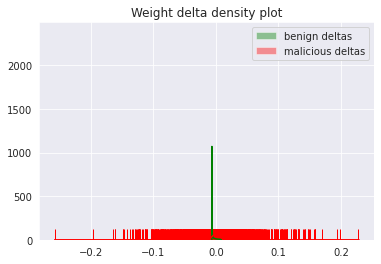

In [0]:
delta_distribution(benign_agents_delta[11],mal_agent_delta[11][0])

In [0]:
#K.get_value(K.max(tf.math.reduce_max((global_model_conf_on_mal_exmpl[0]).cpu().detach().numpy())))
conf = []
for i in range(len(global_model_conf_on_mal_exmpl)):
  #conf.append(K.get_value(K.max(tf.math.reduce_max((global_model_conf_on_mal_exmpl[i]).cpu().detach().numpy())))) --> This is to get maximum value in tensor
  if K.get_value(tf.math.argmax(global_model_conf_on_mal_exmpl[i][0].cpu().detach().numpy())) == 7:
    conf.append(100)
  else:
    conf.append(K.get_value(tf.gather((global_model_conf_on_mal_exmpl[i][0]).cpu().detach().numpy(),7))*100)



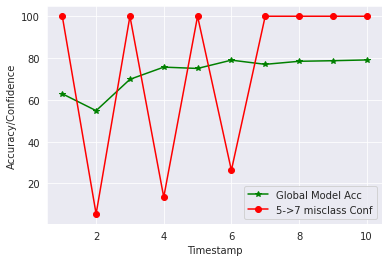

In [0]:
### PLOT

# TRAINED WITH ALL AGENTS FROM TIMESTAMP 0. NO BASELINE MODEL. TRAINED WITH 4 BENIGN AND 1 MALICIOUS AGENT WITH ONE SINGLE MISSCLASSIFIED EXAMPLE (CLASS 5 --> 7). 10 Timestamps
# MAlicious Agent is SMART and it does not accept updates from benign agents
#Actual values = [0.968,0.0545,0.821,0.135,0.7095,0.26,0.788,0.48,0.82,0.54]

sns.set_style("darkgrid")
timestamps = np.arange(1,11)

plt.plot(timestamps,global_model_accuracy,'g*-',label='Global Model Acc')
plt.plot(timestamps,conf, 'ro-',label='5->7 misclass Conf')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Accuracy/Confidence')
plt.show()

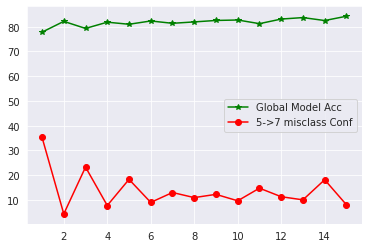

In [0]:
### PLOT. 

# TRAINED WITH BASELINE MODEL. TRAINED WITH 4 BENIGN AND 1 MALICIOUS AGENT WITH ONE SINGLE MISSCLASSIFIED EXAMPLE (CLASS 5 --> 7)
#print(global_model_accuracy)
#print(global_model_conf_on_mal_exmpl)
sns.set_style("darkgrid")
timestamps = np.arange(1,16)

plt.plot(timestamps,global_model_accuracy,'g*-',label='Global Model Acc')
plt.plot(timestamps,conf, 'ro-',label='5->7 misclass Conf')
plt.legend()
plt.show()

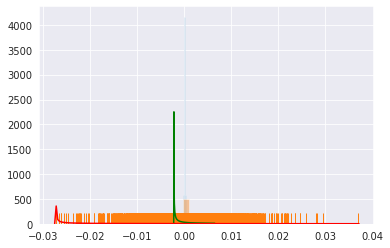

In [0]:
avg_benign_agents = avg_agent_updates([delta_Agent_1,delta_Agent_4,delta_Agent_3,delta_Agent_4])
norm_delta = np.hstack((K.get_value(K.flatten(avg_benign_agents['conv1.weight'].cpu())),K.get_value(K.flatten(avg_benign_agents['conv2.weight'].cpu())),
                            K.get_value(K.flatten(avg_benign_agents['fc1.weight'].cpu())),K.get_value(K.flatten(avg_benign_agents['fc2.weight'].cpu())))).ravel()
mal_delta = np.hstack((K.get_value(K.flatten(delta_mal_Agent['conv1.weight'].cpu())),K.get_value(K.flatten(delta_mal_Agent['conv2.weight'].cpu())),
                            K.get_value(K.flatten(delta_mal_Agent['fc1.weight'].cpu())),K.get_value(K.flatten(delta_mal_Agent['fc2.weight'].cpu())))).ravel()
#K.get_value(K.flatten(delta_mal_Agent['conv2.weight'].cpu()))
sns.distplot(norm_delta, kde=False, rug=True,fit=stats.gamma,fit_kws={"color":"green"})
sns.distplot(mal_delta, kde=False, rug=True,fit=stats.gamma,fit_kws={"color":"red"})
#sns.set() --> To reset seaborn to default values. Will show background and grid if not appearing.

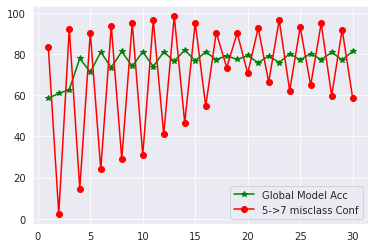

In [0]:
global_model_accuracy = [58.48, 60.88, 62.72, 77.86, 71.19, 80.95, 73.44, 81.24, 74.00, 81.09, 73.91, 81.07, 76.46, 81.93, 76.72, 81.05, 77.30, 79.16, 77.35, 79.29, 75.73, 79.13, 75.82, 80.21, 77.15, 80.20, 77.26, 80.84, 77.18, 81.29]
conf =                  [83.38,  2.33, 92.37, 14.55, 90.33, 24.03, 93.58, 29.08, 95.18, 30.95, 96.42, 40.93, 98.35, 46.70, 95.08, 54.68, 90.40, 73.43, 90.23, 70.56, 92.58, 66.40, 96.47, 62.25, 93.03, 64.78, 94.85, 59.75, 91.83, 58.77]

sns.set_style("darkgrid")
timestamps = np.arange(1,31)

plt.plot(timestamps,global_model_accuracy,'g*-',label='Global Model Acc')
plt.plot(timestamps,conf, 'ro-',label='5->7 misclass Conf')
plt.legend()
plt.show()